<a href="https://colab.research.google.com/github/Mahsa33/Body-Shape-Classification/blob/main/BodyShape_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from collections import namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
from torch import  autograd
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as T
from torchvision import transforms
from torchvision import models
import torch.utils.model_zoo as model_zoo

import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import os
import time
import pprint
import importlib

import PIL
import io
import os, sys

from IPython.display import display, display_markdown

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, resnet101,resnet18,resnet34
from PIL import Image
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import torch.nn.functional as F
import os

In [ ]:
# Define a helper function to load and combine dictionaries
def load_and_combine_dicts(*file_paths):
    combined_dict = {}
    for file_path in file_paths:
        loaded_dict = np.load(file_path, allow_pickle=True).item()
        combined_dict.update(loaded_dict)
    return combined_dict

# Load and combine the dictionaries
segmented_masks_apple = load_and_combine_dicts('/content/drive/MyDrive/seg_final_data/Apple_segmented_masks.npy')
segmented_masks_hour = load_and_combine_dicts('/content/drive/MyDrive/seg_final_data/Hourglass_segmented_masks.npy')
segmented_masks_invert = load_and_combine_dicts('/content/drive/MyDrive/thesis_datasets/seg_final_data/InvertedTriangle_segmented_masks.npy')
segmented_masks_rec = load_and_combine_dicts('/content/drive/MyDrive/thesis_datasets/seg_final_data/Rectangle_segmented_masks.npy')
segmented_masks_triangle = np.load('/content/drive/MyDrive/thesis_datasets/seg_final_data/Triangle_segmented_masks.npy', allow_pickle=True).item()

In [ ]:
print('Apple',len(segmented_masks_apple))
print('Hourglass',len(segmented_masks_hour))
print('InvertedTriangle',len(segmented_masks_invert))
print('Rectangle',len(segmented_masks_rec))
print('Triangle',len(segmented_masks_triangle))

Apple 901
Hourglass 1168
InvertedTriangle 1062
Rectangle 1108
Triangle 985


In [ ]:
def label(new_key, segment_dict):

  grouped_list = [value for value in segment_dict.values()]
  grouped_dict = {new_key: grouped_list}
  return grouped_dict

segmented_masks_Apple = label('Apple',segmented_masks_apple)
segmented_masks_Hour = label('Hourglass', segmented_masks_hour)
segmented_masks_Invert = label('InvertedTriangle', segmented_masks_invert)
segmented_masks_Rec = label('Rectangle', segmented_masks_rec)
segmented_masks_Triangle = label('Triangle',segmented_masks_triangle)

In [ ]:
segmented_masks = [
    segmented_masks_Apple,
    segmented_masks_Hour,
    segmented_masks_Invert,
    segmented_masks_Rec,
    segmented_masks_Triangle,

]

all_segment = {}

for mask in segmented_masks:
  all_segment.update(mask)

In [ ]:
def reshape_batch_tensors(df):
    rows_not_equal_1 = df[df.iloc[:, 1].apply(lambda x: x.shape[0] != 1)]
    filtered_rows = []

    for index, row in rows_not_equal_1.iterrows():
        tensor_batch = row[1]
        if tensor_batch.shape[0] > 1:
            row[1] = tensor_batch[0].unsqueeze(0)
            filtered_rows.append(row)

    filtered_df = pd.DataFrame(filtered_rows, columns=df.columns)
    df = df.drop(rows_not_equal_1.index)
    df = pd.concat([df, filtered_df], ignore_index=True)

    df.iloc[:, 1] = np.array(
        [t.squeeze().repeat(3, 1, 1) for t in df.iloc[:, 1].values]
    )

    return df

In [ ]:
df = pd.DataFrame(data=((k, imgs) for k, v in all_segment.items() for imgs in v))
new_train_df = reshape_batch_tensors(df)

In [ ]:
label_encoder = LabelEncoder()
new_train_df[0] = label_encoder.fit_transform(new_train_df[0])

In [ ]:
new_train_df[0].value_counts()

1    1148
3    1080
2    1026
4     965
0     866
Name: 0, dtype: int64

In [ ]:
new_train_df[1][50].shape

torch.Size([3, 3416, 3414])

In [ ]:
new_train_df.tail(5)

,0,1
5080,4,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
5081,4,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
5082,4,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
5083,4,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
5084,4,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."


In [ ]:
segmented_test = load_and_combine_dicts('/content/drive/MyDrive/thesis_datasets/seg_final_data/Test_segmented_masks.npy')

test_df = pd.DataFrame(data=((k, imgs) for k, v in segmented_test.items() for imgs in v))
new_test_df = reshape_batch_tensors(test_df)

In [ ]:
def rename(name):
  name = name.split('_')[0]
  return name

new_test_df[0] = new_test_df[0].apply(lambda x: rename(x))
new_test_df[0] = label_encoder.fit_transform(new_test_df[0])

In [ ]:
class CustomDataset():
  def __init__(self, values, keys, transform):
    self.data = list(values)
    self.labels = list(keys)
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    x = self.data[index].float()
    y = self.labels[index]

    # Define the maximum width and height for resizing
    max_width = 299
    max_height = 299
    # Calculate the aspect ratio of the original image
    aspect_ratio = x.shape[2] / x.shape[1]

    # Calculate the new width and height while maintaining the aspect ratio
    if aspect_ratio > 1:
        new_width = max_width
        new_height = int(max_width / aspect_ratio)
    else:
        new_height = max_height
        new_width = int(max_height * aspect_ratio)

    # Resize the image while preserving the aspect ratio
    resize_transform = transforms.Resize((new_height, new_width))
    resized_tensor = resize_transform(x)

    # Pad the tensor if necessary
    pad_transform = transforms.Pad((0, 0, max_width - new_width, max_height - new_height))
    padded_tensor = pad_transform(resized_tensor)


    return padded_tensor, y

In [ ]:
train_keys, val_keys, train_values, val_values = train_test_split(new_train_df[0], new_train_df[1], test_size=0.2, random_state=42)

In [ ]:
train_dataset = CustomDataset(train_values, train_keys,transform = None)
val_dataset = CustomDataset(val_values, val_keys, transform = None)
test_dataset = CustomDataset(new_test_df[1], new_test_df[0], transform = None)

In [ ]:
# Define batch sizes and other DataLoader parameters
batch_size = 64
shuffle = True
num_workers = 4


# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# CNN Network

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(64, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.3)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2))


        self.flat = nn.Flatten()

        self.fc5 = nn.Linear(10368, 512)
        self.act5 = nn.ReLU()
        self.drop5 = nn.Dropout(0.5)

        self.fc6 = nn.Linear(512, 5)

    def forward(self, x):
        # input 3x299x299, output 128x149x149
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        x = self.pool1(x)

        # input 128x149x149, output 64x74x74
        x = self.act2(self.conv2(x))
        x = self.pool2(x)

        # input 64x74x74, output 64x37x37
        x = self.act3(self.conv3(x))
        x = self.drop3(x)
        x = self.pool3(x)

        # input 64x37x37, output 32x18x18
        x = self.act4(self.conv4(x))
        x = self.pool4(x)

        # input 32x18x18, output 10368
        x = self.flat(x)

        # input 10368, output 512
        x = self.act5(self.fc5(x))
        x = self.drop5(x)
        # input 512, output 5
        x = self.fc6(x)
        return x

In [ ]:
# GPU / CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# instantiating model
model = ConvNet()

# defining optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# defining criterion
criterion = nn.CrossEntropyLoss()

# Total parameters
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

5377925

In [ ]:
num_classes = 5
NUM_EPOCHS = 30


# Training loop
trainingEpoch_loss = []
validationEpoch_loss = []

for epoch in range(1, NUM_EPOCHS + 1):

  print(f'Starting epoch {epoch}')

  # Set current loss value
  current_loss = 0.0
  # Training
  step_loss = []
  model.train()

  # cal one epoch time
  start = time.time()
  correct = 0
  total = 0

  for i, data in enumerate(train_loader, 0):
      # Forward pass

      images , labels = data[0].to(device), data[1].to(device)

      model = model.to(device)
      outputs = model(images)
      criterion = criterion.to(device)
      loss = criterion(outputs, labels)
      step_loss.append(loss.item())
      # backward pass
      optimizer.zero_grad()
      loss.backward()
      # update weights
      optimizer.step()

      current_loss += loss.item()

      if i  % 80 == 79:
        print('Loss after mini-batch %5d: %.3f' %
              (i , current_loss / 80))
        current_loss = 0.0

      #step += 1
      # equal prediction and acc
      _, predicted = torch.max(outputs.data, 1)
      # val_loader total
      total += labels.size(0)
      # add correct
      correct += (predicted == labels).sum().item()

      print(f"Acc: {correct / total:.4f}.")
  trainingEpoch_loss.append(np.array(step_loss).mean())

  # cal train one epoch time
  end = time.time()

  print(f"Epoch [{epoch}/{NUM_EPOCHS}], "
          f"time: {end - start} sec!")


  torch.save(model.state_dict(), 'model.pth')

  val_loss = []
  # Validation
  model.eval()
  with torch.no_grad():
      total_correct_val = 0
      total_examples_val = 0
      for images_val, labels_val in val_loader:
          validationStep_loss = []

          images_val = images_val.to(device)
          labels_val = labels_val.to(device)
          outputs_val = model(images_val)

          validation_loss = criterion(outputs_val, labels_val)
          validationStep_loss.append(validation_loss.item())
          _, predicted_val = torch.max(outputs_val, 1)
          total_correct_val += (predicted_val == labels_val).sum().item()
          total_examples_val += labels_val.size(0)
      validationEpoch_loss.append(np.array(validationStep_loss).mean())

  val_accuracy = total_correct_val / total_examples_val
  print('Validation accuracy: %.3f' % val_accuracy)


# Process is complete.
print('Training process has finished. Saving trained model.')

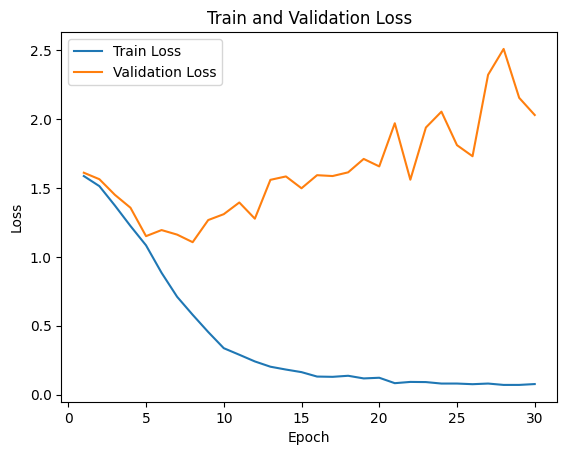

In [ ]:
# Plot the train and validation loss
plt.plot(range(1, NUM_EPOCHS+1), trainingEpoch_loss, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), validationEpoch_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Test
from sklearn.metrics import precision_score, recall_score, f1_score

results = {}
print('Starting testing')
model.eval()
with torch.no_grad():

    true_labels = []
    predicted_labels = []

    test_correct = 0
    test_total = 0
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features.float())
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

    #test_accuracy = test_correct / test_total
    # Print accuracy
     #print('Accuracy for fold %d: %d %%' % (fold, 100.0 * test_correct / test_total))
    print('--------------------------------')
    #results[fold] = 100.0 * (test_correct / test_total)


precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

#print('Precision: %.3f' % precision)
#print('Recall: %.3f' % recall)
#print('F1-score: %.3f' % f1)

from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))

Starting testing


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

--------------------------------
              precision    recall  f1-score   support

           0       0.21      0.29      0.24        17
           1       0.46      0.36      0.40       141
           2       0.26      0.25      0.26        59
           3       0.42      0.40      0.41       112
           4       0.14      0.37      0.21        19

    accuracy                           0.35       348
   macro avg       0.30      0.34      0.30       348
weighted avg       0.38      0.35      0.36       348



In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Apple','Hourglass','Inverted','Rectangle','Triangle'])

disp.plot()
plt.show()

#ResNet

In [ ]:
from torch.optim.lr_scheduler import StepLR
from torch.optim import RMSprop
num_classes = 5

# Load the pretrained ResNet model
# Load the pre-trained ResNet model
model = resnet34(pretrained=True)

# Freeze the first 34 layers of the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last 5 layers of the model
for param in model.layer4.parameters():
    param.requires_grad = True

# Modify the last layer to match the number of body shape classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = RMSprop(model.fc.parameters(), lr=0.0006, weight_decay=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.0006, weight_decay=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_classes = 5
NUM_EPOCHS = 10


# Training loop
trainingEpoch_loss = []
validationEpoch_loss = []

for epoch in range(1, NUM_EPOCHS + 1):

  print(f'Starting epoch {epoch}')

  # Set current loss value
  current_loss = 0.0
  # Training
  step_loss = []
  model.train()

  # cal one epoch time
  start = time.time()
  correct = 0
  total = 0

  for i, data in enumerate(train_loader, 0):
      # Forward pass

      images , labels = data[0].to(device), data[1].to(device)

      model = model.to(device)
      outputs = model(images)
      criterion = criterion.to(device)
      loss = criterion(outputs, labels)
      step_loss.append(loss.item())
      # backward pass
      optimizer.zero_grad()
      loss.backward()
      # update weights
      optimizer.step()

      current_loss += loss.item()

      if i  % 80 == 79:
        print('Loss after mini-batch %5d: %.3f' %
              (i , current_loss / 80))
        current_loss = 0.0

      #step += 1
      # equal prediction and acc
      _, predicted = torch.max(outputs.data, 1)
      # val_loader total
      total += labels.size(0)
      # add correct
      correct += (predicted == labels).sum().item()

      print(f"Acc: {correct / total:.4f}.")
  trainingEpoch_loss.append(np.array(step_loss).mean())

  # cal train one epoch time
  end = time.time()

  print(f"Epoch [{epoch}/{NUM_EPOCHS}], "
          f"time: {end - start} sec!")


  torch.save(model.state_dict(), 'model.pth')

  val_loss = []
  # Validation
  model.eval()
  with torch.no_grad():
      total_correct_val = 0
      total_examples_val = 0
      for images_val, labels_val in val_loader:
          validationStep_loss = []

          images_val = images_val.to(device)
          labels_val = labels_val.to(device)
          outputs_val = model(images_val)

          validation_loss = criterion(outputs_val, labels_val)
          validationStep_loss.append(validation_loss.item())
          _, predicted_val = torch.max(outputs_val, 1)
          total_correct_val += (predicted_val == labels_val).sum().item()
          total_examples_val += labels_val.size(0)
      validationEpoch_loss.append(np.array(validationStep_loss).mean())

  val_accuracy = total_correct_val / total_examples_val
  print('Validation accuracy: %.3f' % val_accuracy)


# Process is complete.
print('Training process has finished. Saving trained model.')

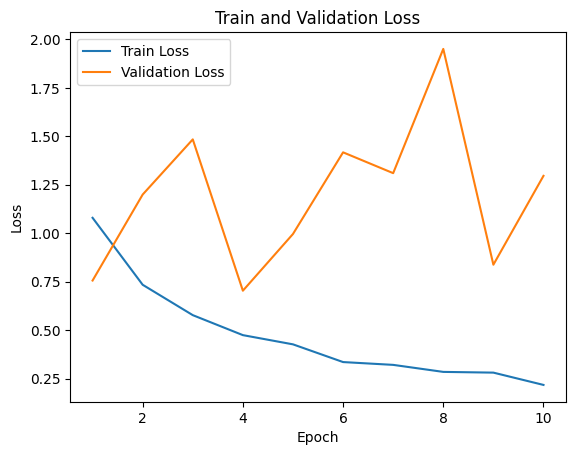

In [ ]:
# Plot the train and validation loss
plt.plot(range(1, NUM_EPOCHS+1), trainingEpoch_loss, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), validationEpoch_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Test
from sklearn.metrics import precision_score, recall_score, f1_score

results = {}
print('Starting testing')
model.eval()
with torch.no_grad():

    true_labels = []
    predicted_labels = []

    test_correct = 0
    test_total = 0
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features.float())
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())



precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')


from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))

Starting testing


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

              precision    recall  f1-score   support

           0       1.00      0.53      0.69        17
           1       0.52      0.48      0.50       141
           2       0.48      0.19      0.27        59
           3       0.46      0.68      0.55       112
           4       0.23      0.26      0.24        19

    accuracy                           0.49       348
   macro avg       0.54      0.43      0.45       348
weighted avg       0.50      0.49      0.47       348



In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Apple','Hourglass','Inverted','Rectangle','Triangle'])

disp.plot()
plt.show()

#VGG16

In [ ]:
# Import the VGG16 model
from torchvision.models import vgg16, vgg19

# Load the pre-trained VGG16 model
model = vgg19(pretrained=True)

# Freeze the first 13 layers of the model
for param in model.parameters():
    param.requires_grad = False

for param in model.features[30 : ].parameters():
  param.requires_grad = True


for param in model.classifier.parameters():
    param.requires_grad = True

# Modify the last layer of the model
model.classifier[6].out_features = 5

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = RMSprop(model.fc.parameters(), lr=0.0006, weight_decay=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
num_classes = 5
NUM_EPOCHS = 20


# Training loop
trainingEpoch_loss = []
validationEpoch_loss = []

for epoch in range(1, NUM_EPOCHS + 1):

  print(f'Starting epoch {epoch}')

  # Set current loss value
  current_loss = 0.0
  # Training
  step_loss = []
  model.train()

  # cal one epoch time
  start = time.time()
  correct = 0
  total = 0

  for i, data in enumerate(train_loader, 0):
      # Forward pass

      images , labels = data[0].to(device), data[1].to(device)

      model = model.to(device)
      outputs = model(images)
      criterion = criterion.to(device)
      loss = criterion(outputs, labels)
      step_loss.append(loss.item())
      # backward pass
      optimizer.zero_grad()
      loss.backward()
      # update weights
      optimizer.step()

      current_loss += loss.item()

      if i  % 80 == 79:
        print('Loss after mini-batch %5d: %.3f' %
              (i , current_loss / 80))
        current_loss = 0.0

      #step += 1
      # equal prediction and acc
      _, predicted = torch.max(outputs.data, 1)
      # val_loader total
      total += labels.size(0)
      # add correct
      correct += (predicted == labels).sum().item()

      print(f"Acc: {correct / total:.4f}.")
  trainingEpoch_loss.append(np.array(step_loss).mean())

  # cal train one epoch time
  end = time.time()

  print(f"Epoch [{epoch}/{NUM_EPOCHS}], "
          f"time: {end - start} sec!")


  torch.save(model.state_dict(), 'model.pth')

  val_loss = []
  # Validation
  model.eval()
  with torch.no_grad():
      total_correct_val = 0
      total_examples_val = 0
      for images_val, labels_val in val_loader:
          validationStep_loss = []

          images_val = images_val.to(device)
          labels_val = labels_val.to(device)
          outputs_val = model(images_val)

          validation_loss = criterion(outputs_val, labels_val)
          validationStep_loss.append(validation_loss.item())
          _, predicted_val = torch.max(outputs_val, 1)
          total_correct_val += (predicted_val == labels_val).sum().item()
          total_examples_val += labels_val.size(0)
      validationEpoch_loss.append(np.array(validationStep_loss).mean())

  val_accuracy = total_correct_val / total_examples_val
  print('Validation accuracy: %.3f' % val_accuracy)


# Process is complete.
print('Training process has finished. Saving trained model.')

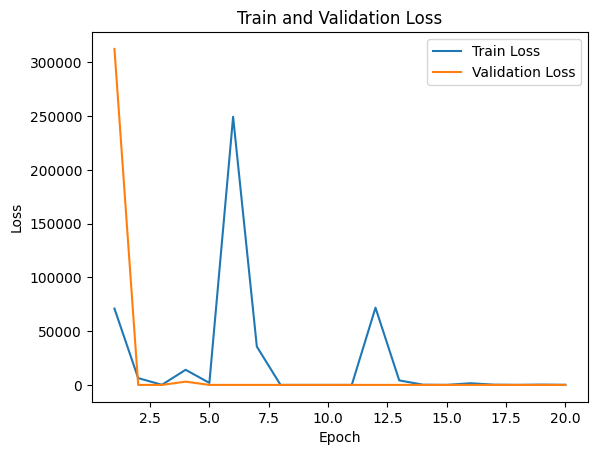

In [ ]:
# Plot the train and validation loss
plt.plot(range(1, NUM_EPOCHS+1), trainingEpoch_loss, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), validationEpoch_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Test
from sklearn.metrics import precision_score, recall_score, f1_score

results = {}
print('Starting testing')
model.eval()
with torch.no_grad():

    true_labels = []
    predicted_labels = []

    test_correct = 0
    test_total = 0
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features.float())
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())



precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')


from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))

Starting testing


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00       141
           2       0.00      0.00      0.00        59
           3       0.32      1.00      0.49       112
           4       0.00      0.00      0.00        19

    accuracy                           0.32       348
   macro avg       0.06      0.20      0.10       348
weighted avg       0.10      0.32      0.16       348



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Apple','Hourglass','Inverted','Rectangle','Triangle'])

disp.plot()
plt.show()

#Inception

In [ ]:
# Import the Inception V3 model
from torchvision.models import inception_v3

# Load the InceptionV3 model
model = models.inception_v3(pretrained=True)

# Modify the last layer to match the number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)

# Unfreeze the last 5 layers
unfreeze_layers = 5
child_count = 0
for child in model.children():
    if child_count >= 9 - unfreeze_layers:  # 9 is the total number of inception blocks in InceptionV3
        for param in child.parameters():
            param.requires_grad = True
    child_count += 1


# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 72.3MB/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
num_classes = 5
NUM_EPOCHS = 30


# Training loop
trainingEpoch_loss = []
validationEpoch_loss = []

for epoch in range(1, NUM_EPOCHS + 1):

  print(f'Starting epoch {epoch}')

  # Set current loss value
  current_loss = 0.0
  # Training
  step_loss = []
  model.train()

  # cal one epoch time
  start = time.time()
  correct = 0
  total = 0

  for i, data in enumerate(train_loader, 0):
      # Forward pass

      images , labels = data[0].to(device), data[1].to(device)
      criterion = criterion.to(device)
      model = model.to(device)
      outputs = model(images)

      loss = criterion(outputs.logits, labels)
      step_loss.append(loss.item())
      # backward pass
      optimizer.zero_grad()
      loss.backward()
      # update weights
      optimizer.step()

      current_loss += loss.item()

      if i  % 80 == 79:
        print('Loss after mini-batch %5d: %.3f' %
              (i , current_loss / 80))
        current_loss = 0.0

      #step += 1
      # equal prediction and acc
      _, predicted = torch.max(outputs.logits, 1)
      # val_loader total
      total += labels.size(0)
      # add correct
      correct += (predicted == labels).sum().item()

      print(f"Acc: {correct / total:.4f}.")
  trainingEpoch_loss.append(np.array(step_loss).mean())

  # cal train one epoch time
  end = time.time()

  print(f"Epoch [{epoch}/{NUM_EPOCHS}], "
          f"time: {end - start} sec!")


  torch.save(model.state_dict(), 'model.pth')

  val_loss = []
  # Validation
  model.eval()
  with torch.no_grad():
      total_correct_val = 0
      total_examples_val = 0
      for images_val, labels_val in val_loader:
          validationStep_loss = []

          images_val = images_val.to(device)
          labels_val = labels_val.to(device)
          outputs_val = model(images_val)

          validation_loss = criterion(outputs_val, labels_val)
          validationStep_loss.append(validation_loss.item())
          _, predicted_val = torch.max(outputs_val, 1)
          total_correct_val += (predicted_val == labels_val).sum().item()
          total_examples_val += labels_val.size(0)
      validationEpoch_loss.append(np.array(validationStep_loss).mean())

  val_accuracy = total_correct_val / total_examples_val
  print('Validation accuracy: %.3f' % val_accuracy)


# Process is complete.
print('Training process has finished. Saving trained model.')

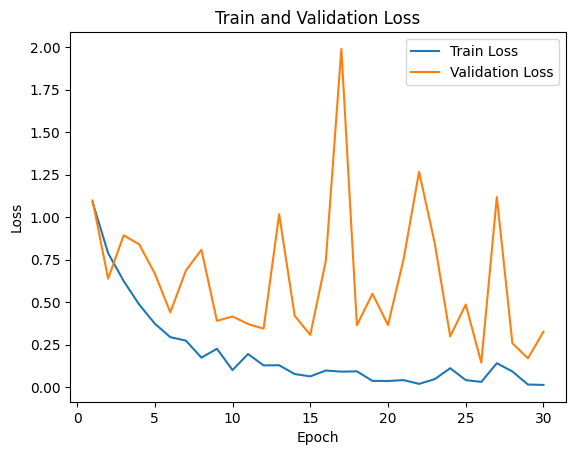

In [ ]:
# Plot the train and validation loss
plt.plot(range(1, NUM_EPOCHS+1), trainingEpoch_loss, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), validationEpoch_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Test
from sklearn.metrics import precision_score, recall_score, f1_score

results = {}
print('Starting testing')
model.eval()
with torch.no_grad():

    true_labels = []
    predicted_labels = []

    test_correct = 0
    test_total = 0
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features.float())
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

    #test_accuracy = test_correct / test_total
    # Print accuracy
     #print('Accuracy for fold %d: %d %%' % (fold, 100.0 * test_correct / test_total))
    print('--------------------------------')
    #results[fold] = 100.0 * (test_correct / test_total)


precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

#print('Precision: %.3f' % precision)
#print('Recall: %.3f' % recall)
#print('F1-score: %.3f' % f1)

from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))

Starting testing


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

--------------------------------
              precision    recall  f1-score   support

           0       0.57      0.71      0.63        17
           1       0.62      0.53      0.57       141
           2       0.30      0.22      0.25        59
           3       0.56      0.71      0.62       112
           4       0.33      0.37      0.35        19

    accuracy                           0.53       348
   macro avg       0.48      0.51      0.49       348
weighted avg       0.53      0.53      0.53       348



In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Apple','Hourglass','Inverted','Rectangle','Triangle'])

disp.plot()
plt.show()